In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

import contextily as ctx

import folium

tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans Narrow'

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#### Get basic spatial units for London

In [2]:
# url = "http://geoportal.statistics.gov.uk/datasets/8edafbe3276d4b56aec60991cbddda50_2.geojson"
# EW = gpd.read_file(url)
# London = EW[EW.lad15cd.str.contains("E09")]
# London.to_file('../data/London_boundaries.geojson', driver = 'GeoJSON')

London = gpd.read_file('../data/london_general/London_boundaries.geojson')
lsoa = gpd.read_file('../data/london_general/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp')
msoa = gpd.read_file('../data/london_general/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')

In [3]:
postcodes = pd.read_csv('../data/london_general/london_postcodes-ons-postcodes-directory-nov2020.csv', low_memory=False)
postcodes = postcodes[postcodes.oslaua.str.contains('E09')]
postcodes = postcodes[['pcd2', 'oa11', 'lsoa11', 'msoa11', 'wz11', 'lat', 'long']]
postcodes.to_csv('../data/london_general/london_postcodes.csv', index=False)

#### Choose high street extent

Option 1. CDRC data

Sources:  
2021 retail boundaries  
https://data.cdrc.ac.uk/dataset/retail-centre-boundaries  
2017 retail boundaries  
https://data.cdrc.ac.uk/dataset/historic-retail-centre-boundaries

In [4]:
# 2017 data
r17 = gpd.read_file('../data/retail/cdrc/retailcentreboundaries.gpkg')

#boundaries updated in 2021
r21 = gpd.read_file('../data/retail/cdrc/Retail_Centres_UK.gpkg')

In [5]:
print(r17.shape)
print(r21.shape)

(3253, 3)
(6423, 6)


In [6]:
r17 = r17.to_crs('EPSG:27700')
r21 = r21.to_crs('EPSG:27700')
London = London.to_crs('EPSG:27700')
msoa = msoa.to_crs('EPSG:27700')

In [7]:
r_London17 = gpd.overlay(r17, London, how='intersection')
r_London21 = gpd.overlay(r21, London, how='intersection')

In [8]:
print(r_London17.shape)
print(r_London21.shape)

(973, 9)
(1256, 12)


In [9]:
r_London17.to_file('../data/retail/cdrc/r_London17.geojson', driver='GeoJSON')
r_London21.to_file('../data/retail/cdrc/r_London21.geojson', driver='GeoJSON')

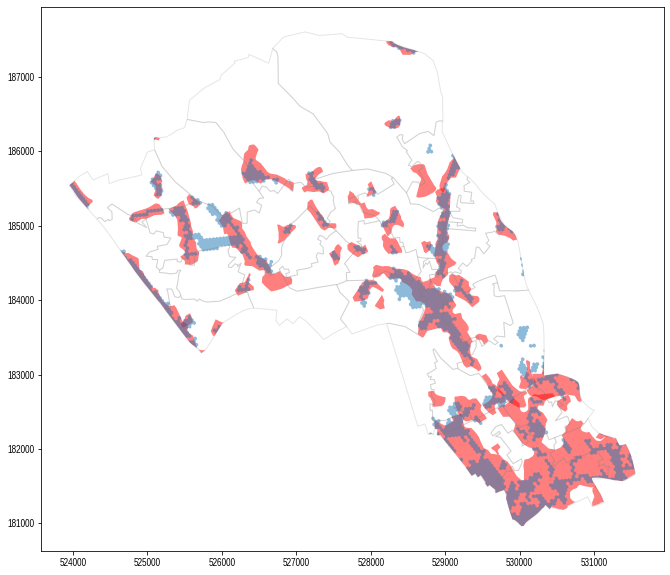

In [10]:
# compare datasets from 2017 and 2021
fig, ax = plt.subplots(figsize=(15,10))

r_London17[r_London17.lad15nm=='Camden'].plot(ax=ax, color='red', alpha=0.5)
r_London21[r_London21.lad15nm=='Camden'].plot(ax=ax, alpha=0.5)
msoa[msoa.LAD11NM.str.contains('Camden')].plot(ax=ax, facecolor = "None", edgecolor = "grey", alpha=0.2);

Above we can see that in 2021 new spatial technique (hexagons) was used. Also the layers do not fully intersect, so the methodology is new too, but not documented. Proceed with 2017 one

Now add CRDC typology to better understand the dataset

In [11]:
r_London17.columns

Index(['id', 'name', 'objectid', 'lad15cd', 'lad15nm', 'lad15nmw',
       'st_areashape', 'st_lengthshape', 'geometry'],
      dtype='object')

In [12]:
r_London17.drop(columns=['objectid', 'lad15cd', 'lad15nmw','st_areashape', 'st_lengthshape'],
                             inplace=True)
r_London17.rename(columns={'id':'retail_id'}, inplace=True)

In [13]:
r_London17[r_London17.name.str.contains('Brecknock')]

,retail_id,name,lad15nm,geometry
17,TC2742,"Brecknock Road, Kentish Town, London",Islington,"POLYGON ((529867.378 185011.185, 529869.235 18..."
457,TC2742,"Brecknock Road, Kentish Town, London",Camden,"POLYGON ((529943.944 184877.799, 529959.240 18..."


In [14]:
# add clusters and subclusters typology
retail_types = pd.read_csv('../data/retail/cdrc/retailcentretypology.csv')
clusters = pd.read_csv('../data/retail/cdrc/cdrc_clusters.csv', sep=';')
subclusters = pd.read_csv('../data/retail/cdrc/cdrc_subclusters.csv', sep=';')
clusters['Cluster'] = clusters['Cluster'].astype(float)

In [15]:
retail_types = retail_types.dropna()
r_London17 = r_London17.merge(retail_types, how='left', left_on='retail_id', right_on='TC_ID')
r_London17 = r_London17.merge(clusters, how='left', left_on='Cluster', right_on='Cluster')
r_London17 = r_London17.merge(subclusters, how='left', left_on='SubCluster', right_on='Subcluster')

In [16]:
r_London17['area'] = round(r_London17.geometry.area)

In [17]:
r_London17.to_file('../data/retail/cdrc/r_London17.geojson', driver='GeoJSON')
r_London17 = gpd.read_file('../data/retail/cdrc/r_London17.geojson')

In [18]:
r_London17.Subcluster_desc.value_counts()

Local urban convenience centres                  230
Diverse urban service centres                    214
Inner urban service centres                      209
More affluent district destinations               82
Diverse & affluent urban leisure destinations     45
Premium shopping & leisure destinations           38
Indie & value oriented high streets               33
Smaller vibrant urban destinations                27
Urban value destinations                          21
Mass market & value retail large centres          19
Suburban & market town high streets               12
Less diverse retail shopping & leisure parks      10
Affluent/premium retail destinations               8
Retail shopping & leisure parks                    5
Name: Subcluster_desc, dtype: int64

In [19]:
camden = r_London17[r_London17.lad15nm=='Camden']
camden.shape

(44, 16)

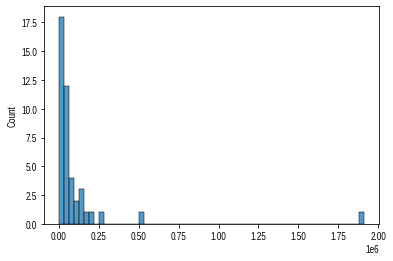

In [20]:
sns.histplot(camden.area);

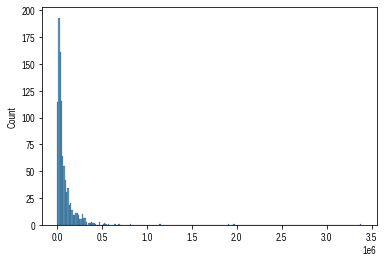

In [21]:
sns.histplot(r_London17.area);

In [22]:
camden[['retail_id','Cluster','Cluster_name']].groupby(['Cluster','Cluster_name']).agg('count').reset_index()

,Cluster,Cluster_name,retail_id
0,1.0,Local retail & service centres,31
1,3.0,Leading comparison & leisure destinations,4
2,4.0,Primary food and secondary comparison destinat...,6
3,5.0,Traditional high streets & market towns,1


In [23]:
camden[['retail_id','Subcluster_desc']].groupby(['Subcluster_desc']).agg('count').reset_index()

,Subcluster_desc,retail_id
0,Affluent/premium retail destinations,1
1,Diverse & affluent urban leisure destinations,1
2,Diverse urban service centres,14
3,Inner urban service centres,9
4,Local urban convenience centres,8
5,More affluent district destinations,4
6,Premium shopping & leisure destinations,3
7,Smaller vibrant urban destinations,1
8,Urban value destinations,1


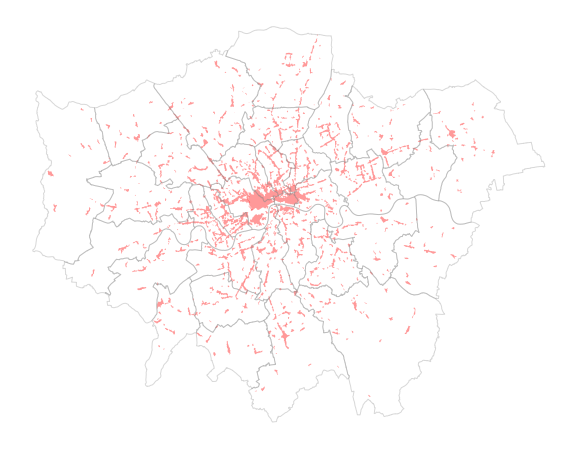

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

r_London17.plot(ax=ax, color='red', alpha=0.4)
London.plot(ax=ax, facecolor = "None", edgecolor = "grey", alpha=0.3)
ax.set_axis_off();

### Compare high streets datasets

In [25]:
gla_hs = gpd.read_file('../data/retail/gla/GLA_High_Street_boundaries.gpkg')

In [26]:
hs_path = '../data/retail/os_high_street_201903/geojson/great_britain/high_street_201903_building_geom.geojson'
ons_hs_buildings_polys = gpd.read_file(hs_path)
ons_hs_buildings_polys = ons_hs_buildings_polys.to_crs('epsg:27700')
ons_hs_buildings_polys = ons_hs_buildings_polys[ons_hs_buildings_polys.region_name1=='LONDON']

In [27]:
r_London17 = gpd.read_file('../data/retail/cdrc/r_London17.geojson')
r_London21 = gpd.read_file('../data/retail/cdrc/r_London.geojson')

In [28]:
r_London17 = r_London17.to_crs('epsg:27700')
r_London21 = r_London21.to_crs('epsg:27700')
gla_hs = gla_hs.to_crs('epsg:27700')
London = London.to_crs('epsg:27700')

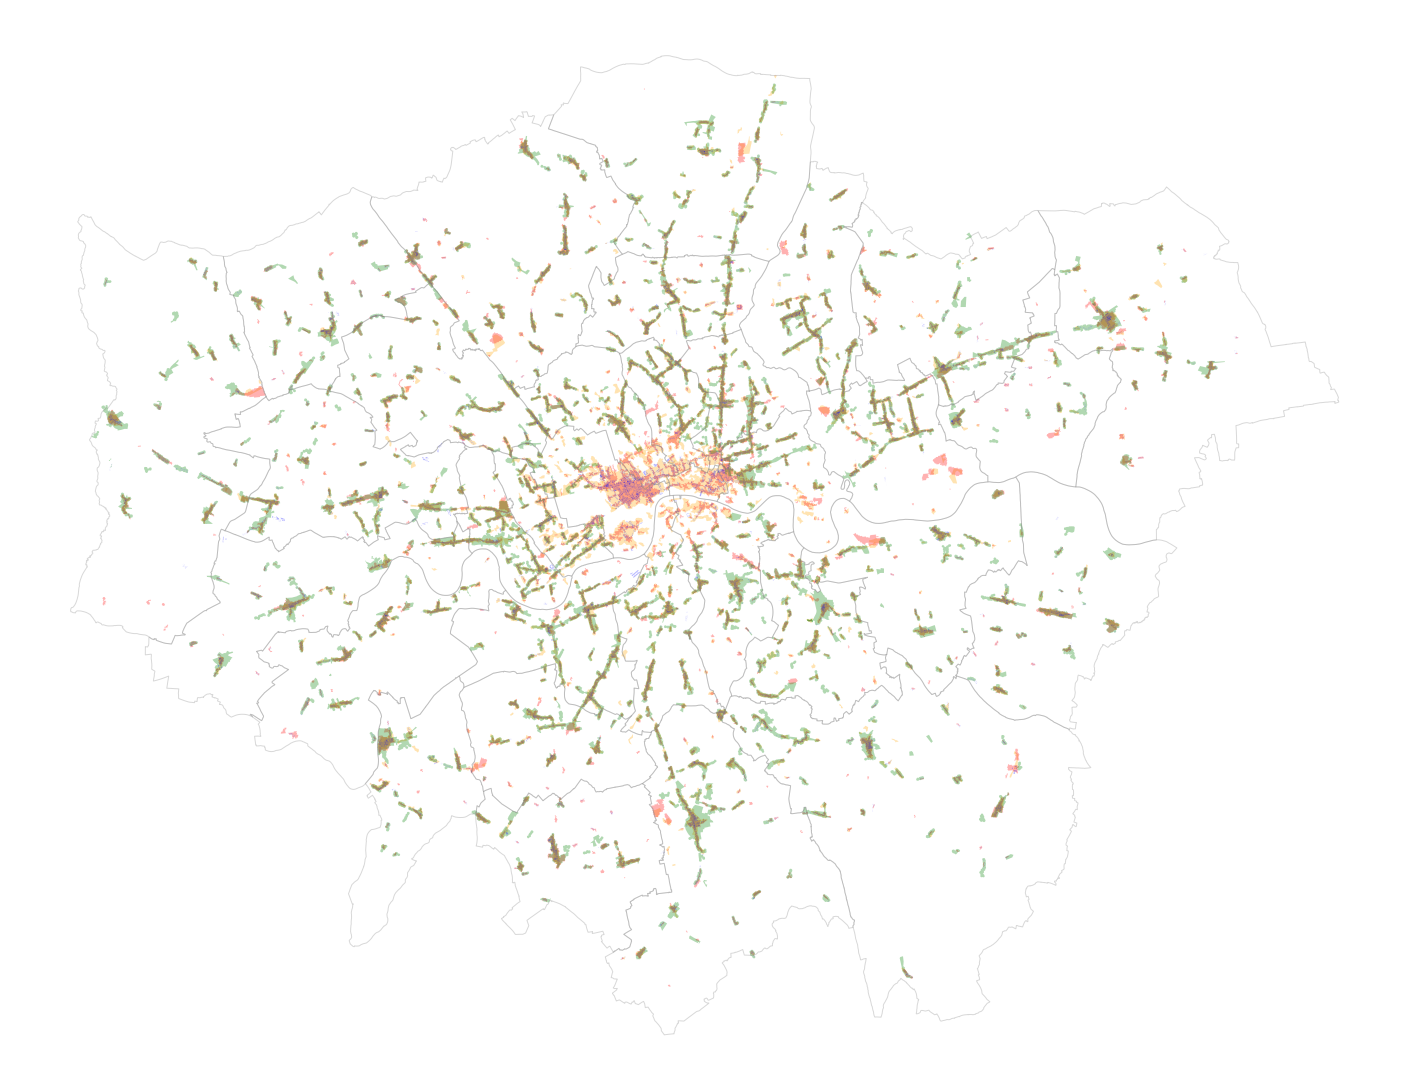

In [29]:
fig, ax = plt.subplots(figsize=(25,20))

r_London17.plot(ax=ax, color='orange', alpha=0.3)
r_London21.plot(ax=ax, color='red', alpha=0.3)

gla_hs.plot(ax=ax, color='green', alpha=0.3)
ons_hs_buildings_polys.plot(ax=ax, color='blue', alpha=0.3)

London.plot(ax=ax, facecolor = "None", edgecolor = "grey", alpha=0.3)
ax.set_axis_off();

In [30]:
# intersected = gpd.overlay(hs_buildings_polys, msoa_cropped, how='intersection')
# intersected['area'] = intersected.geometry.area
# msoa_hs_area = intersected.groupby(by='MSOA11CD').area.sum().reset_index()
# msoa_hs_area.columns = ['MSOA11CD', 'hs_building_area']

In [31]:
London.head()

,objectid,lad15cd,lad15nm,lad15nmw,st_areashape,st_lengthshape,geometry
0,294,E09000001,City of London,,3.149379e+06,9601.634809,"POLYGON ((532142.105 182192.150, 532136.705 18..."
1,295,E09000002,Barking and Dagenham,,3.779933e+07,36966.973941,"POLYGON ((548883.672 190803.293, 548888.172 19..."
2,296,E09000003,Barnet,,8.674831e+07,50818.481665,"POLYGON ((524581.602 198355.621, 524564.501 19..."
3,297,E09000004,Bexley,,6.428646e+07,43418.867756,"POLYGON ((552178.708 178417.893, 552158.908 17..."
4,298,E09000005,Brent,,4.323264e+07,38334.060960,"POLYGON ((520286.392 190241.738, 520255.890 19..."


In [32]:
inner_london = ['City of London',
 'Camden',
 'Greenwich',
 'Hackney',
 'Hammersmith and Fulham',
 'Islington',
 'Kensington and Chelsea',
 'Lambeth',
 'Lewisham',
 'Southwark',
 'Tower Hamlets',
 'Wandsworth',
 'Westminster']

inner_bb = London[London['lad15nm'].isin(inner_london)].total_bounds

from shapely.geometry import Polygon
bb = Polygon([(523000, 174000), (523000, 186000),(540000, 186000),
                  (540000, 174000)])
inner_bbox = gpd.GeoDataFrame({'geometry': gpd.GeoSeries(bb)}, crs='epsg:27700')

In [33]:
inner_bb

array([521056.52633658, 169648.02263577, 547613.91960067, 188327.64113082])

In [34]:
London.head(2)

,objectid,lad15cd,lad15nm,lad15nmw,st_areashape,st_lengthshape,geometry
0,294,E09000001,City of London,,3.149379e+06,9601.634809,"POLYGON ((532142.105 182192.150, 532136.705 18..."
1,295,E09000002,Barking and Dagenham,,3.779933e+07,36966.973941,"POLYGON ((548883.672 190803.293, 548888.172 19..."


In [35]:
intersections_r_London17 = gpd.overlay(r_London17, inner_bbox, how='intersection')
intersections_r_London21 = gpd.overlay(r_London21, inner_bbox, how='intersection')
intersections_gla_hs = gpd.overlay(gla_hs, inner_bbox, how='intersection')
intersections_ons_hs_buildings_polys = gpd.overlay(ons_hs_buildings_polys, inner_bbox, how='intersection')
intersections_London = gpd.overlay(London, inner_bbox, how='intersection')
intersections_msoa = gpd.overlay(msoa, inner_bbox, how='intersection')

In [36]:
#create label column and merge into one gdf to have one legend on a map
intersections_r_London17['label'] = 'CDRC'
intersections_gla_hs['label'] = 'GLA'
intersections_ons_hs_buildings_polys['label'] = 'ONS'

intersections_r_London17 = intersections_r_London17.loc[:, ['label', 'geometry']]
intersections_gla_hs = intersections_gla_hs.loc[:, ['label', 'geometry']]
intersections_ons_hs_buildings_polys = intersections_ons_hs_buildings_polys.loc[:, ['label', 'geometry']]

intersections_r_London17_df = pd.DataFrame(intersections_r_London17)
intersections_gla_hs_df = pd.DataFrame(intersections_gla_hs)
intersections_ons_hs_buildings_polys_df = pd.DataFrame(intersections_ons_hs_buildings_polys)

df_list = [intersections_r_London17_df, intersections_gla_hs_df, intersections_ons_hs_buildings_polys_df]
cropped_hs = gpd.GeoDataFrame(pd.concat(df_list, ignore_index=True))

In [37]:
hmap = colors.ListedColormap([ 'lightblue', 'pink', 'red'])

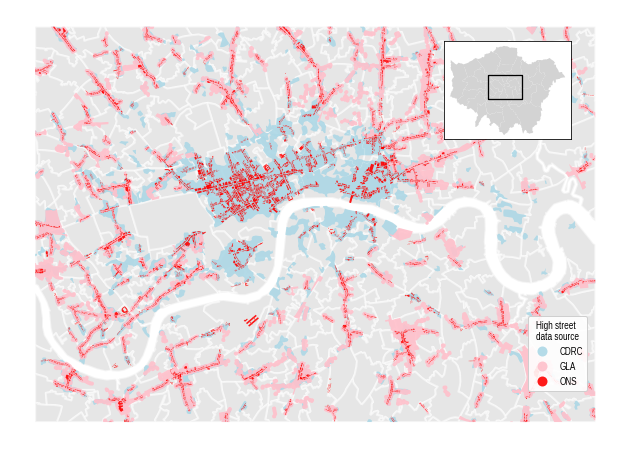

In [38]:
fig,ax = plt.subplots(figsize=(12,8))

intersections_msoa.plot(ax=ax, facecolor='lightgrey', edgecolor='white', linewidth=2, alpha=0.55)
cropped_hs.plot(ax=ax, column='label', legend=True, cmap=hmap, alpha=0.9,
                legend_kwds=dict(bbox_to_anchor=(0.75, 0.1, 0.2, 0.2), 
                                   title="High street \ndata source", frameon=True, framealpha=0.9))
ax.set_axis_off()
# ax.tick_params(
#     axis='both', bottom=False, left=False,         
#     labelbottom=False, labelleft=False)

ax2 = fig.add_axes([0.65, 0.65, 0.17, 0.17])
London.plot(facecolor='lightgrey', edgecolor='None', ax=ax2)
inner_bbox.plot(facecolor='None', edgecolor='black', linewidth=1.3, ax=ax2)
ax2.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False)

# fig.savefig('../output/hs_compare_map.png', bbox_inches='tight')